**Import libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

**Load Dataset**

In [4]:
dataset = pd.read_csv(r'C:\Users\Wisdom Duru\Downloads\nsclc_pd1_msk_2018_clinical_data.csv')
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0    Study ID                        240 non-null    object 
 1   Patient ID                       240 non-null    object 
 2   Sample ID                        240 non-null    object 
 3   Diagnosis Age                    240 non-null    int64  
 4   Cancer Type                      240 non-null    object 
 5   Cancer Type Detailed             240 non-null    object 
 6   Durable Clinical Benefit         240 non-null    object 
 7   FGA                              240 non-null    float64
 8   Fraction Genome Altered          240 non-null    float64
 9   Gene Panel                       240 non-null    object 
 10  IRB                              240 non-null    object 
 11  Lines of treatment               240 non-null    int64  
 12  Mutation Count        

,Study ID,Patient ID,Sample ID,Diagnosis Age,Cancer Type,Cancer Type Detailed,Durable Clinical Benefit,FGA,Fraction Genome Altered,Gene Panel,...,Oncotree Code,PD-L1 Score (%),Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sex,Smoker,Somatic Status,TMB (nonsynonymous),Treatment Type
0,nsclc_pd1_msk_2018,P-0000012,P-0000012-T03-IM3,58,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,YES,0.18,0.1844,IMPACT341,...,LUAD,NaN,27.20,0:Not Progressed,1,Female,Ever,Matched,32.165504,Combination
1,nsclc_pd1_msk_2018,P-0000082,P-0000082-T01-IM3,60,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,YES,0.36,0.3606,IMPACT341,...,LUAD,100.0,14.50,1:Progressed,1,Male,Ever,Matched,1.109155,Monotherapy
2,nsclc_pd1_msk_2018,P-0000208,P-0000208-T01-IM3,68,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NO,0.12,0.1173,IMPACT341,...,LUAD,3.0,4.17,1:Progressed,1,Female,Ever,Matched,2.218311,Monotherapy
3,nsclc_pd1_msk_2018,P-0000235,P-0000235-T01-IM3,77,Non-Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,NO,0.24,0.2380,IMPACT341,...,LUSC,NaN,0.60,1:Progressed,1,Male,Ever,Matched,8.873242,Monotherapy
4,nsclc_pd1_msk_2018,P-0000299,P-0000299-T01-IM3,66,Non-Small Cell Lung Cancer,Large Cell Neuroendocrine Carcinoma,NO,0.01,0.0051,IMPACT341,...,LUNE,NaN,1.63,1:Progressed,1,Male,Ever,Matched,7.764087,Combination


**Filter Non-Smokers and select key Genetic Features from dataset**

In [6]:
# Filter for non-smokers
non_smokers_dataset = dataset[dataset["Smoker"] == "Never"].copy()

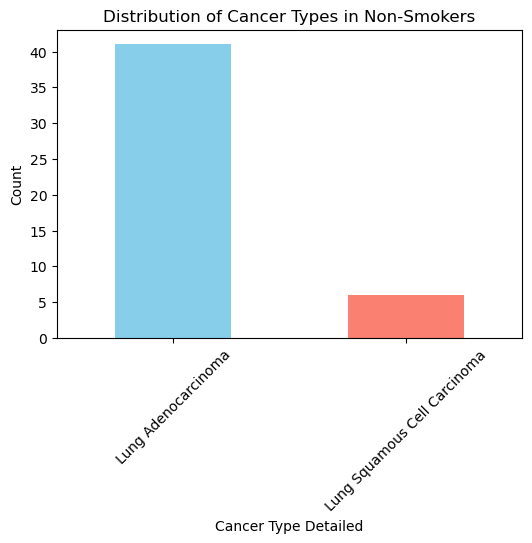

In [7]:
# Plot distribution of Cancer Type Detailed in non-smokers
plt.figure(figsize=(6, 4))
non_smokers_dataset["Cancer Type Detailed"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.xlabel("Cancer Type Detailed")
plt.ylabel("Count")
plt.title("Distribution of Cancer Types in Non-Smokers")
plt.xticks(rotation=45)
plt.show()


In [8]:
# Select relevant genetic alteration features
genetic_features = ["TMB (nonsynonymous)", "Mutation Count", "Fraction Genome Altered", "Cancer Type Detailed"]

# Summary statistics for risk threshold determination
non_smokers_dataset[genetic_features].describe(include ="all")

,TMB (nonsynonymous),Mutation Count,Fraction Genome Altered,Cancer Type Detailed
count,47.000000,47.000000,47.000000,47
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,Lung Adenocarcinoma
freq,NaN,NaN,NaN,41
mean,4.472212,4.489362,0.168219,NaN
std,2.852997,2.819747,0.177442,NaN
min,0.978720,1.000000,0.000000,NaN
25%,2.936159,3.000000,0.028550,NaN
50%,3.914879,4.000000,0.131400,NaN
75%,5.366983,6.000000,0.276750,NaN


**Define Levels of Risks**

In [10]:
# Define new risk categories: High Risk (1), Medium Risk (0.5), Low Risk (0)
def classify_risk(row):
    if row["Cancer Type Detailed"] == "Lung Adenocarcinoma":
        if (row["TMB (nonsynonymous)"] >= 5.37) or (row["Mutation Count"] >= 6) or (row["Fraction Genome Altered"] >= 0.28):
            return 1  # High Risk: LUAD + high genetic markers
        else:
            return 0.5  # Medium Risk: LUAD but without high genetic markers
    else:
        return int(
            (row["TMB (nonsynonymous)"] >= 5.37) or 
            (row["Mutation Count"] >= 6) or 
            (row["Fraction Genome Altered"] >= 0.28)
        )

# Apply the new classification
non_smokers_dataset["Risk Level"] = non_smokers_dataset.apply(classify_risk, axis=1)

# Check distribution of new risk levels
non_smokers_dataset["Risk Level"].value_counts()



Risk Level
1.0    22
0.5    22
0.0     3
Name: count, dtype: int64

C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_15872\2007551338.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset["Diagnosis Age"], palette="coolwarm")


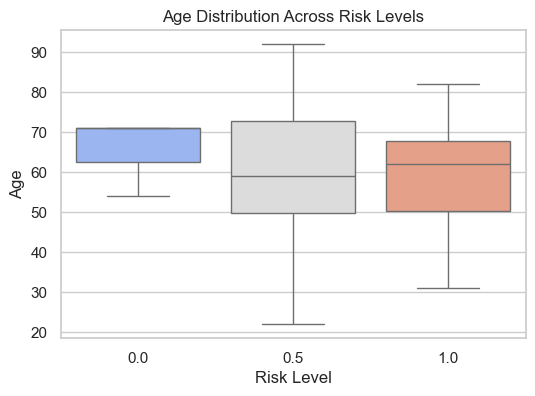

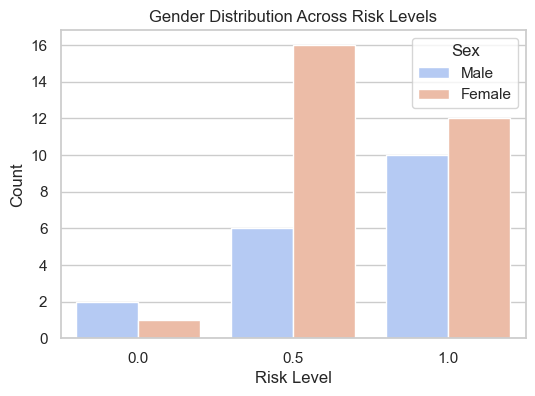

In [11]:
# Set plot style
sns.set(style="whitegrid")

# 🔹 Boxplot: Age vs. Risk Level
plt.figure(figsize=(6, 4))
sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset["Diagnosis Age"], palette="coolwarm")
plt.xlabel("Risk Level")
plt.ylabel("Age")
plt.title("Age Distribution Across Risk Levels")
plt.show()

# 🔹 Bar Chart: Gender vs. Risk Level
plt.figure(figsize=(6, 4))
sns.countplot(x=non_smokers_dataset["Risk Level"], hue=non_smokers_dataset["Sex"], palette="coolwarm")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.title("Gender Distribution Across Risk Levels")
plt.legend(title="Sex")
plt.show()

**Visualizing the Major features**

In [ ]:
# Select top most important features
top_features = ["Fraction Genome Altered", "Mutation Count", "Mutation Rate","TMB (nonsynonymous)"]

# Set plot style
sns.set(style="whitegrid")

# Create subplots for boxplots (feature vs. risk level)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Generate boxplots
for i, feature in enumerate(top_features):
    sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset[feature], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"{feature} vs. Risk Level")
    axes[i].set_xlabel("Risk Level")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_15872\3570384045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset[feature], ax=axes[i], palette="coolwarm")
C:\Users\Wisdom Duru\AppData\Local\Temp\ipykernel_15872\3570384045.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=non_smokers_dataset["Risk Level"], y=non_smokers_dataset[feature], ax=axes[i], palette="coolwarm")


In [ ]:
# Plot distribution of Risk Levels
plt.figure(figsize=(6, 4))
non_smokers_dataset["Risk Level"].value_counts().sort_index().plot(kind="bar", color=["lightgreen", "gold", "red"])
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.title("Distribution of Risk Levels in Non-Smokers")
plt.xticks(ticks=[0, 1, 2], labels=["Low Risk (0.0)", "Medium Risk (0.5)", "High Risk (1.0)"], rotation=45)
plt.show()


**Feature Scaling**

In [ ]:
# Ensure 'Cancer Type Detailed' is encoded properly
non_smokers_dataset["Cancer_Type_Encoded"] = LabelEncoder().fit_transform(non_smokers_dataset["Cancer Type Detailed"])

In [ ]:
# Create interaction terms
non_smokers_dataset["Mutation_FGA_Interaction"] = non_smokers_dataset["Mutation Count"] * non_smokers_dataset["Fraction Genome Altered"]
non_smokers_dataset["TMB_Mutation_Interaction"] = non_smokers_dataset["TMB (nonsynonymous)"] * non_smokers_dataset["Mutation Count"]

**PCA**

In [ ]:
# Apply PCA to genetic features
genetic_features_pca = ["TMB (nonsynonymous)", "Mutation Count", "Fraction Genome Altered", "Mutation Rate"]
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(non_smokers_dataset[genetic_features_pca])
non_smokers_dataset["PCA_1"] = pca_transformed[:, 0]
non_smokers_dataset["PCA_2"] = pca_transformed[:, 1]


**Cluster Genetic features**

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
non_smokers_dataset["Genetic_Cluster"] = kmeans.fit_predict(non_smokers_dataset[genetic_features_pca])

In [ ]:
# Final feature set
enhanced_features = [
    "Fraction Genome Altered", "Mutation Count", "Mutation Rate", "Sex", "Diagnosis Age",
    "Mutation_FGA_Interaction", "TMB_Mutation_Interaction", "PCA_1", "PCA_2", "Genetic_Cluster", "Cancer_Type_Encoded"
]

**Correlation matrix**

In [ ]:
# Select only numeric columns
numeric_df = non_smokers_dataset.select_dtypes(include=["number"]).drop(columns=["Number of Samples Per Patient"], errors="ignore")

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Matrix (Non-Smokers)")
plt.show()

**TRAINING THE SVM MODEL WITH RBF KERNEL**

In [ ]:
# Convert risk levels into categorical classes
y_risk_class = non_smokers_dataset["Risk Level"].map({0.0: 0, 0.5: 1, 1.0: 2})  # Mapping to class labels


In [ ]:
# Ensure all features are numeric
X_risk_fixed = non_smokers_dataset[enhanced_features]
X_risk_fixed = X_risk_fixed.loc[:, ~X_risk_fixed.columns.duplicated()]  # Remove duplicates if any

In [ ]:
# Split data again with 25% test size
X_train_risk_class, X_test_risk_class, y_train_risk_class, y_test_risk_class = train_test_split(
    X_risk_fixed, y_risk_class, test_size=0.3, random_state=0, stratify=y_risk_class
)

In [ ]:
# Perform one-hot encoding
X_train_risk_class = pd.get_dummies(X_train_risk_class, columns=['Sex'], drop_first=True)
X_test_risk_class = pd.get_dummies(X_test_risk_class, columns=['Sex'], drop_first=True)

In [ ]:
# Standardize features
scaler_risk_class = StandardScaler()
X_train_scaled_risk_class = scaler_risk_class.fit_transform(X_train_risk_class)
X_test_scaled_risk_class = scaler_risk_class.transform(X_test_risk_class)

In [ ]:
print(X_train_risk_class.dtypes)

In [ ]:
# Train SVM with RBF kernel for multi-class classification
svm_risk_class_model = SVC(kernel="rbf", C=1, gamma= "scale", probability=True, random_state=0)
svm_risk_class_model.fit(X_train_scaled_risk_class, y_train_risk_class)

In [ ]:
# Evaluate model performance
train_acc_risk_class = svm_risk_class_model.score(X_train_scaled_risk_class, y_train_risk_class)
test_acc_risk_class = svm_risk_class_model.score(X_test_scaled_risk_class, y_test_risk_class)


In [ ]:
# Output results
(train_acc_risk_class, test_acc_risk_class)

In [ ]:
# Make predictions on the entire test set
y_pred = svm_risk_class_model.predict(X_test_scaled_risk_class)

# Compare predicted vs. actual risk levels
comparison_df = pd.DataFrame({
    "Actual Risk Level": y_test_risk_class.values,
    "Predicted Risk Level": y_pred
})

# Display the first few comparisons
print(comparison_df.head())
print(comparison_df.info())

# Calculate accuracy
accuracy = (comparison_df["Actual Risk Level"] == comparison_df["Predicted Risk Level"]).mean()
print(f"Model Accuracy on Test Set: {accuracy:.2%}")


In [ ]:
# Select the first row from the test set
instance_1 = X_test_risk_class.iloc[[0]]  # First row (index 0)
actual_risk_1 = y_test_risk_class.iloc[0]  # Actual risk level

# Standardize the instance using the same scaler
instance_1_scaled = scaler_risk_class.transform(instance_1)

# Make prediction
predicted_risk_1 = svm_risk_class_model.predict(instance_1_scaled)


# Display the results
print(f"Row 1 - Actual Risk Level: {actual_risk_1}")
print(f"Row 1 - Predicted Risk Level: {predicted_risk_1[0]}")



**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(y_test_risk_class, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_risk_class, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted Risk Level")
plt.ylabel("Actual Risk Level")
plt.title("Confusion Matrix - SVM Model")
plt.show()


In [ ]:
import joblib  

joblib.dump(svm_risk_class_model, "svm_lung_cancer_in_non_smokers_model.pkl")

print("Model saved successfully!")